# CONFIGURE Notebook for Google Drive:

In [2]:
#Google specific code

!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

!mkdir -p drive
!google-drive-ocamlfuse drive

gpg: keybox '/tmp/tmpn4m0iwyh/pubring.gpg' created
gpg: /tmp/tmpn4m0iwyh/trustdb.gpg: trustdb created
gpg: key AD5F235DF639B041: public key "Launchpad PPA for Alessandro Strada" imported
gpg: Total number processed: 1
gpg:               imported: 1
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
Please enter the verification code: Access token retrieved correctly.


In [0]:
import os
os.chdir("/content/drive/app")

In [0]:
import pandas as pd
import numpy as np

import pandas as pd
import numpy as np

import cv2
from cv2 import boxPoints

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.patches as patches
import matplotlib as mpl

from PIL import Image

# LOAD Data:

In [4]:
import pandas as pd
train_df = pd.read_csv("munich/train_df.csv")
test_df = pd.read_csv("munich/test_df.csv")
train_df.head()


id type  center_x  center_y  width  height       angle      filename  \
0   0  car      2261      1455     22      11   47.202598  4K0G0010.JPG   
1   1  car      3195      2542     18       9  -34.911830  4K0G0010.JPG   
2   2  car      1444      2367     23      11  102.736400  4K0G0010.JPG   
3   3  car       535       851     21      10  -37.288108  4K0G0010.JPG   
4   4  car      2245      1442     19       9   44.039825  4K0G0010.JPG   

                             orig_filename  x_min  y_min  x_max  y_max  
0  2012-04-26-Muenchen-Tunnel_4K0G0010.JPG   2237   1431   2284   1478  
1  2012-04-26-Muenchen-Tunnel_4K0G0010.JPG   3175   2524   3214   2559  
2  2012-04-26-Muenchen-Tunnel_4K0G0010.JPG   1428   2342   1459   2391  
3  2012-04-26-Muenchen-Tunnel_4K0G0010.JPG    512    830    557    871  
4  2012-04-26-Muenchen-Tunnel_4K0G0010.JPG   2225   1422   2264   1461

In [0]:
train_df.id = train_df.index
test_df.id = test_df.index

In [0]:
train_filenames = train_df.orig_filename.unique()
test_filenames = test_df.orig_filename.unique()

In [6]:

import os
cwd = os.getcwd()
print(cwd)

/content/drive/app


# Load Car Of Interest:

id                                                    64
type                                                 car
center_x                                            3506
center_y                                             427
width                                                 20
height                                                10
angle                                           -93.4682
filename                                    4K0G0040.JPG
orig_filename    2012-04-26-Muenchen-Tunnel_4K0G0040.JPG
x_min                                               3494
y_min                                                406
x_max                                               3517
y_max                                                447
Name: 500, dtype: object
/content/drive/app/munich/train_images/2012-04-26-Muenchen-Tunnel_4K0G0040.JPG
88 111 79 120


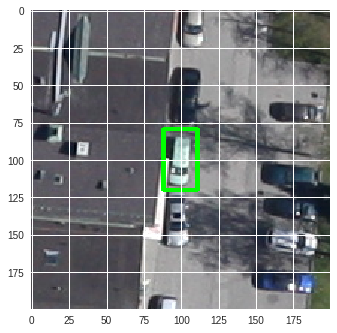

In [84]:
def show_car_of_interest(car_id, df, window_size):
    
    car_info = df.iloc[car_id]
       
    print(car_info)
    file_location = cwd + "/munich/train_images/" + car_info.orig_filename
    print(file_location)
  
    image = cv2.imread(file_location)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    car_center_x, car_center_y, car_x_min , car_y_min, car_x_max, car_y_max = int(car_info.center_x), int(car_info.center_y), int(car_info.x_min), int(car_info.y_min), int(car_info.x_max), int(car_info.y_max)
    
    car_win_y_min = int(car_center_y-window_size if car_y_min-window_size > 0 else window_size)
    car_win_y_max = int(car_center_y+window_size if car_y_max+window_size < image.shape[0] else window_size)  #newImage.shape[0])
    car_win_x_min = int(car_center_x-window_size if car_x_min-window_size > 0 else window_size)
    car_win_x_max = int(car_center_x+window_size if car_x_max+window_size < image.shape[1] else  window_size)
    
    
    car_x_min = car_x_min - car_win_x_min
    car_x_max = car_x_max - car_win_x_min
    car_y_min = car_y_min - car_win_y_min
    car_y_max = window_size*2 - (car_win_y_max - car_y_max)

def crop_img(image, car_x_min, car_x_max, car_y_min, car_y_max):
  
    windowImg = image.copy()[car_win_y_min:car_win_y_max, car_win_x_min:car_win_x_max]

    cv2.rectangle(windowImg, (car_x_min, car_y_min) , (car_x_max, car_y_max), (0, 255, 0), 2)    

     #  if doing a slidign window can crop and then modulo
    
#     x_min = bounding_cars.x_min - car_win_x_min
#     x_max = bounding_cars.x_max - car_win_x_min
#     y_min = bounding_cars.y_min - car_win_y_min
#     y_max = window_size*2 - (car_win_y_max - bounding_cars.y_max)
    print(car_x_min, car_x_max, car_y_min, car_y_max)
    
    
    plt.imshow(windowImg)
    

  
show_car_of_interest(500, train_df, window_size = 100)

# Crop windows and prepare for tf record write:

In [0]:
def iterate_over_data(df, filename, save_path, window_size, data_size, car_type, train_or_test, save):
  
    file_df = df[(df['orig_filename'] == filename) & (df.type == car_type)]
    
    file_location = cwd + "/munich/"+ train_or_test + "_images/" + file_df.iloc[0].orig_filename
    
    
    print(file_location)
    image = cv2.imread(file_location)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
    cars_ct = 0
    
    new_df = pd.DataFrame()
    
    print("# of images being generated: ",len(file_df.id[0:data_size]))
    for car_id in file_df.id[0:data_size]:
      
        # select car of interst
        car_info = file_df[file_df.id == car_id]
        
        windowImg, bounding_cars = grab_window(car_info, window_size, file_df)
        
        car_filename = str("car_" + str(car_id) + "_" + file_df.iloc[0].orig_filename)
        indiv_df = pd.DataFrame()
        
        indiv_df["type"] = bounding_cars.type
        indiv_df["orig_filename"] = car_filename
        indiv_df["width"] = bounding_cars.width.astype("int")
        indiv_df["height"] = bounding_cars.height.astype("int")
        indiv_df["xmin"] = bounding_cars.x_min.astype("int")
        indiv_df["ymin"] = bounding_cars.y_min.astype("int")
        indiv_df["xmax"] = bounding_cars.x_max.astype("int")
        indiv_df["ymax"] = bounding_cars.y_max.astype("int")

        if save:
            directory_images = save_path+train_or_test+"_images/"
            print(directory_images)
            if not os.path.exists(directory_images):
              os.makedirs(directory_images)
            cv2.imwrite(bounding_img_path, cv2.cvtColor(windowImg, cv2.COLOR_RGB2BGR))
            
       
def grab_window(car_info, window_size, file_df):
    """select car of interest, extract window of specified size, convert bboxes to new dimensions and save"""
    
    # find window of cars and cars found in window
    
    
    # select cars within window of car of interst
    bounding_cars = file_df[(file_df.x_min > car_win_x_min) & (file_df.x_max < car_win_x_max) & (file_df.y_min > car_win_y_min) & (file_df.y_max < car_win_y_max)]
    
    # convert pixel dimensions to that of window

    bounding_cars.x_min = bounding_cars.x_min - car_win_x_min
    bounding_cars.x_max = bounding_cars.x_max - car_win_x_min
    bounding_cars.y_min = bounding_cars.y_min - car_win_y_min
    bounding_cars.y_max = window_size*2 - (car_win_y_max - bounding_cars.y_max)
    
    windowImg = image.copy()[car_win_y_min:car_win_y_max, car_win_x_min:car_win_x_max]
       # if no cars found
    if bounding_cars.shape[0] == 0 or bounding_cars.shape[0] > 50:
        pass
            
    return windowImg, bounding_cars
      
     
    
        # add cars count
        
        # create new image of window
        #windowImg = image.copy()[car_win_y_min:car_win_y_max, car_win_x_min:car_win_x_max]
        
        # draw rectangles for visualization
        
#         outputImg = windowImg.copy()
#         for index, row in bounding_cars.iterrows():
    
#             cv2.rectangle(outputImg, (row.x_min, row.y_min) , (row.x_max, row.y_max), (0, 255, 0), 2)

#             #outputImg=newImage[car_win_y_min:car_win_y_max, car_win_x_min:car_win_x_max]
        
            
        # create dataframe for kitti format
        
#         car_filename = str("car_" + str(car_id) + "_" + file_df.iloc[0].orig_filename)
#         indiv_df = pd.DataFrame()

        
        
#         indiv_df["type"] = bounding_cars.type
#         indiv_df["orig_filename"] = car_filename
#         indiv_df["width"] = bounding_cars.width.astype("int")
#         indiv_df["height"] = bounding_cars.height.astype("int")
#         indiv_df["xmin"] = bounding_cars.x_min.astype("int")
#         indiv_df["ymin"] = bounding_cars.y_min.astype("int")
#         indiv_df["xmax"] = bounding_cars.x_max.astype("int")
#         indiv_df["ymax"] = bounding_cars.y_max.astype("int")

#         indiv_df.columns = ["type", "orig_filename","width","height","xmin","ymax","xmax","ymin"]
#         new_df = new_df.append(indiv_df)
        
    
#         # save paths
#         bounding_img_path = save_path+train_or_test+"_images/"  + car_filename
#         print(bounding_img_path)
#         # save 
#         if save:
#             directory_images = save_path+train_or_test+"_images/"
#             print(directory_images)
#             if not os.path.exists(directory_images):
#               os.makedirs(directory_images)
#             cv2.imwrite(bounding_img_path, cv2.cvtColor(windowImg, cv2.COLOR_RGB2BGR))
      
#     if save:  
#       directory_labels = save_path+train_or_test+"_labels/"
      
#       print(directory_labels)
#       if not os.path.exists(directory_labels):
#         os.makedirs(directory_labels)
      
#       bounding_df_file_path = save_path+train_or_test+"_labels/" + filename.replace(".JPG",".csv")
#       new_df.to_csv(bounding_df_file_path, index = False)

#     print ("total cars found in set:", new_df.shape[0])


In [94]:
dummy_crop_path = cwd+"/munich/crop_data/"

grab_window(train_df, train_filenames[4], save_path = dummy_crop_path, window_size = 200, data_size = 10, car_type = "car", train_or_test = "train", save = True)


/content/drive/app/munich/train_images/2012-04-26-Muenchen-Tunnel_4K0G0051.JPG
# of images being generated:  10


/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:3643: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


/content/drive/app/munich/crop_data/train_images/car_0_2012-04-26-Muenchen-Tunnel_4K0G0051.JPG
/content/drive/app/munich/crop_data/train_images/
/content/drive/app/munich/crop_data/train_images/car_1_2012-04-26-Muenchen-Tunnel_4K0G0051.JPG
/content/drive/app/munich/crop_data/train_images/
/content/drive/app/munich/crop_data/train_images/car_2_2012-04-26-Muenchen-Tunnel_4K0G0051.JPG
/content/drive/app/munich/crop_data/train_images/
/content/drive/app/munich/crop_data/train_images/car_4_2012-04-26-Muenchen-Tunnel_4K0G0051.JPG
/content/drive/app/munich/crop_data/train_images/
/content/drive/app/munich/crop_data/train_images/car_5_2012-04-26-Muenchen-Tunnel_4K0G0051.JPG
/content/drive/app/munich/crop_data/train_images/
/content/drive/app/munich/crop_data/train_images/car_6_2012-04-26-Muenchen-Tunnel_4K0G0051.JPG
/content/drive/app/munich/crop_data/train_images/
/content/drive/app/munich/crop_data/train_images/car_7_2012-04-26-Muenchen-Tunnel_4K0G0051.JPG
/content/drive/app/munich/crop_data

In [0]:
label_df = pd.read_csv("munich/crop_data/train_labels/2012-04-26-Muenchen-Tunnel_4K0G0051.csv")

In [96]:
label_df.head()

type                                  orig_filename  width  height  xmin  \
0  car  car_0_2012-04-26-Muenchen-Tunnel_4K0G0051.JPG     24      12   179   
1  car  car_0_2012-04-26-Muenchen-Tunnel_4K0G0051.JPG     19       9   204   
2  car  car_0_2012-04-26-Muenchen-Tunnel_4K0G0051.JPG     20      10   101   
3  car  car_0_2012-04-26-Muenchen-Tunnel_4K0G0051.JPG     21      10    82   
4  car  car_0_2012-04-26-Muenchen-Tunnel_4K0G0051.JPG     21      10    74   

   ymax  xmax  ymin  
0   173   220   226  
1    84   247   117  
2   276   146   313  
3   238   129   275  
4   223   121   258

In [0]:
flag_data = cwd+"/munich/crop_data/train_images/"
flag_labels = cwd+"/munich/crop_data/train_labels/2012-04-26-Muenchen-Tunnel_4K0G0051.csv"
flag_output = cwd+"/munich/"

In [0]:
#  python generate_tfrecord.py --json_input=data/test_labels.csv  --output_path=test.record --data_path=data/test/

!python generate_tfrecord_from_csv_format.py \
--annotation_file=munich/crop_data/train_labels/2012-04-26-Muenchen-Tunnel_4K0G0051.csv \
--output_path=munich/train.record \
--data_path=munich/crop_data/train_images/


/usr/local/lib/python3.6/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [0]:
ls munich

crop_data/          test_df.csv   train_df.csv   train.record
munich_train.ipynb  test_images/  train_images/
